# Трек 1. Обучение агента в классической среде

## 1. Выбор среды и дизайн исследования

В качестве рабочей среды выберем Acrobot-v1

В Acrobot-v1 цель состоит в том, чтобы поднять конец плеча до определенной высоты за минимальное количество шагов. Чем дольше эпизод, тем хуже агент справляется с задачей, потому что он не может достичь цели и продолжает двигаться до максимального количества шагов (500)

Обучение агента проведем с помощью алгоритма PPO. По умолчанию этот алгоритм имеет параметры gamma=0.99, архитектура [64,64]

В качестве двух контролируемых экспериментов предлагается:
1. Увеличить коэффициент дисконтирования gamma с 0.99 до 0.999
2. Изменить архитектуру модели:
    - Уменьшить до [32,32]
    - Увеличить до [256,256]

Все эксперименты проводятся с фиксированным seed и на одном кол-ве timestamps

Будем руководствоваться следующей структурой проекта

```
.\
├── RL_Track1.ipynb
├── logs\
│   ├── baseline\             # gamma=0.99, архитектура [64,64] (по умолчанию)
│   │   ├── baseline.monitor.csv
│   │   └── tensorboard\
│   └── gamma_0999\          # Эксперимент 1: gamma=0.999, архитектура [64,64]
│   │   ├── gamma_0999.monitor.csv
│   │   └── tensorboard\
│   ├── net_small\            # Эксперимент 2: gamma=0.99, архитектура [32,32]
│   │   ├── net_small.monitor.csv
│   │   └── tensorboard\
│   ├── net_large\            # Эксперимент 2: gamma=0.99, архитектура [256,256]
│   │   ├── net_large.monitor.csv
│   └── └── tensorboard\
├── models\
│   ├── ppo_acrobot_baseline.zip
│   ├── ppo_acrobot_gamma_0999.zip
│   ├── ppo_acrobot_net_small.zip
│   └── ppo_acrobot_net_large.zip
├── videos\
│   ├── baseline.mp4
│   ├── gamma_0.999.mp4
│   ├── net_small.mp4 
└── └── net_large.mp4 
```

В рамках данной работы мы построим и обучим 4 модели

- Базовую модель PPO (gamma=0.99, архитектура [64,64])
- Эксперимент 1: gamma=0.999, архитектура [64,64]
- Эксперимент 2: gamma=0.99, архитектура [32,32]
- Эксперимент 2: gamma=0.99, архитектура [256,256]

## 2. Обучение baseline агента

Импортируем необходимые библиотеки

In [1]:
import numpy as np
import pandas as pd
import torch
import gymnasium as gym
import matplotlib.pyplot as plt
import os
from pathlib import Path
from tqdm.auto import tqdm

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

import cv2

Фиксируем случайность

In [2]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

os.environ['PYTHONHASHSEED'] = str(SEED)

In [3]:
print(f"Gymnasium: {gym.__version__}")
print(f"Stable Baselines3: {PPO.__module__}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA is available: {torch.cuda.is_available()}")

Gymnasium: 1.2.2
Stable Baselines3: stable_baselines3.ppo.ppo
PyTorch: 2.3.1
CUDA is available: True


Для оптимизации работы, воспользуемся функциональным подходом и сходу определим функции, которыми будем пользоваться для построения всех моделей

In [ ]:
# Функция создания среды с правильной структурой логов
def create_environment(experiment_name, seed=None):
    """
    Создает среду Acrobot-v1 с правильной структурой логов

    :param experiment_name: Имя эксперимента (baseline, gamma_0999, net_small, net_large)
    :param seed: Фиксированный seed для воспроизводимости
    :return: Обернутая среда, путь к логам
    """
    # Создание директории для логов эксперимента
    log_dir = os.path.join("./logs", experiment_name)
    os.makedirs(log_dir, exist_ok=True)

    # Инициализация среды
    env = gym.make("Acrobot-v1", render_mode="rgb_array")

    # Обертка Monitor для сбора метрик
    # Важно: Monitor автоматически добавит расширение .monitor.csv
    monitor_path = os.path.join(log_dir, experiment_name)
    env = Monitor(env, filename=monitor_path, allow_early_resets=True)

    # Векторизация среды
    env = DummyVecEnv([lambda: env])

    # Фиксация seed
    if seed is not None:
        env.seed(seed)
        env.action_space.seed(seed)

    print(f"Среда для '{experiment_name}' создана. Логи: {log_dir}/{experiment_name}.monitor.csv")
    return env, log_dir

In [ ]:
# Функция обучения модели с параметрами gamma и архитектуры сети
def train_ppo_model(
    experiment_name,
    gamma=0.99,
    net_arch=None,
    seed=42,
    total_timesteps=100_000
):
    """
    Обучает модель PPO с заданными параметрами

    :param experiment_name: Имя эксперимента (baseline, gamma_0999, net_small, net_large)
    :param gamma: Коэффициент дисконтирования (0.99 по умолчанию)
    :param net_arch: Архитектура сети [скрытые_слои] или None для базовой [64, 64]
    :param seed: Фиксированный seed
    :param total_timesteps: Общее количество шагов обучения
    :return: Путь к сохраненной модели, данные о наградах
    """
    print(f"Эксперимент: {experiment_name}")
    print(f"   gamma = {gamma}, net_arch = {net_arch if net_arch else '[64, 64] (по умолчанию)'}")

    # 1. Создание среды
    env, log_dir = create_environment(experiment_name, seed)

    # 2. Настройка архитектуры сети
    policy_kwargs = None
    if net_arch is not None:
        policy_kwargs = dict(net_arch=net_arch)
        print(f"Используется кастомная архитектура сети: {net_arch}")

    # 3. Инициализация модели PPO
    tb_log_dir = os.path.join(log_dir, "tensorboard")
    model = PPO(
        policy="MlpPolicy",
        env=env,
        seed=seed,
        verbose=1,
        gamma=gamma,
        policy_kwargs=policy_kwargs,
        tensorboard_log=tb_log_dir,
        device="cpu"
    )

    # 4. Обучение агента
    print(f"Обучение {experiment_name} на {total_timesteps:,} шагов")
    model.learn(
        total_timesteps=total_timesteps,
        progress_bar=True,
        log_interval=1000,  # Выводим таблицы только каждые 1000 шагов
        tb_log_name=experiment_name
    )

    # 5. Сохранение модели
    model_dir = "./models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"ppo_acrobot_{experiment_name}.zip")
    model.save(model_path)

    print(f"Модель сохранена в: {model_path}")

    # 6. Сбор данных о наградах из monitor файла
    monitor_path = os.path.join(log_dir, f"{experiment_name}.monitor.csv")
    rewards = []

    if os.path.exists(monitor_path):
        with open(monitor_path, 'r') as f:
            for line in f:
                # Пропускаем комментарии и заголовок
                if line.startswith('#') or line.startswith('r,l,t') or not line.strip():
                    continue
                try:
                    reward = float(line.split(',')[0])
                    rewards.append(reward)
                except (ValueError, IndexError):
                    continue
        print(f"Загружено {len(rewards)} эпизодов из {os.path.basename(monitor_path)}")
    else:
        print(f"Файл не найден: {monitor_path}. Награды не будут доступны для анализа")

    # 7. Закрытие среды
    env.close()

    return model_path, rewards

In [ ]:
# Функция для записи видео работы обученной модели
def record_agent_video(model_path, video_name, max_steps=500, seed=42):
    """
    Записывает видео работы обученной модели

    :param model_path: Путь к сохраненной модели (.zip)
    :param video_name: Имя видео файла (без расширения)
    :param max_steps: Максимальное количество шагов для записи
    :param seed: Фиксированный seed для воспроизводимости
    :return: Путь к сохраненному видео
    """
    print(f"Запись видео для {os.path.basename(model_path)}")

    # 1. Создание директории для видео
    video_dir = "./videos"
    os.makedirs(video_dir, exist_ok=True)
    video_path = os.path.join(video_dir, f"{video_name}.mp4")

    # 2. Загрузка модели
    model = PPO.load(model_path, device="cpu")

    # 3. Создание среды для оценки
    eval_env = gym.make("Acrobot-v1", render_mode="rgb_array")
    eval_env.reset(seed=seed)

    # 4. Получение первого кадра для определения размеров
    obs, _ = eval_env.reset()
    frame = eval_env.render()
    height, width, _ = frame.shape

    # 5. Инициализация видеозаписи
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(video_path, fourcc, 30, (width, height))

    # 6. Запись эпизода
    episode_reward = 0
    for step in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        episode_reward += reward

        frame = eval_env.render()
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame_bgr)

        if terminated or truncated:
            break

    # 7. Завершение записи
    video.release()
    eval_env.close()

    print(f"    Видео сохранено в: {video_path}")
    print(f"    Длина эпизода: {step+1} шагов, суммарная награда: {episode_reward:.1f}")
    return video_path

In [7]:
TOTAL_TIMESTEPS = 100_000

In [8]:
# 1. Обучение baseline модели (gamma=0.99, архитектура [64,64] по умолчанию)
baseline_model_path, baseline_rewards = train_ppo_model(
    experiment_name="baseline",
    gamma=0.99,           # Значение по умолчанию для PPO
    net_arch=None,        # Используем архитектуру по умолчанию [64, 64]
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS
)

Эксперимент: baseline
   gamma = 0.99, net_arch = [64, 64] (по умолчанию)
Среда для 'baseline' создана. Логи: ./logs\baseline/baseline.monitor.csv
Using cpu device
Обучение baseline на 100,000 шагов
Logging to ./logs\baseline\tensorboard\baseline_1


Output()

Модель сохранена в: ./models\ppo_acrobot_baseline.zip
Загружено 933 эпизодов из baseline.monitor.csv


In [9]:
# 2. Запись видео для baseline
baseline_video_path = record_agent_video(
    model_path=baseline_model_path,
    video_name="baseline",
    max_steps=500,
    seed=SEED
)

Запись видео для ppo_acrobot_baseline.zip


c:\Users\avmar\anaconda3\envs\GAN_venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


    Видео сохранено в: ./videos\baseline.mp4
    Длина эпизода: 83 шагов, суммарная награда: -82.0


## 3. Проведение экспериментов

### Эксперимент 1: Влияние gamma (коэффициент дисконтирования)

Гипотеза: Увеличение gamma (0.99 -> 0.999) улучшит долгосрочное планирование агента в Acrobot-v1, но замедлит сходимость из-за увеличения дисперсии обновлений

In [10]:
# Обучение модели с gamma=0.999
gamma_0999_model_path, gamma_0999_rewards = train_ppo_model(
    experiment_name="gamma_0999",
    gamma=0.999,           # Увеличенный gamma
    net_arch=None,         # Архитектура по умолчанию [64, 64] (как в baseline)
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS
)

Эксперимент: gamma_0999
   gamma = 0.999, net_arch = [64, 64] (по умолчанию)
Среда для 'gamma_0999' создана. Логи: ./logs\gamma_0999/gamma_0999.monitor.csv
Using cpu device
Обучение gamma_0999 на 100,000 шагов
Logging to ./logs\gamma_0999\tensorboard\gamma_0999_1


Output()

Модель сохранена в: ./models\ppo_acrobot_gamma_0999.zip
Загружено 885 эпизодов из gamma_0999.monitor.csv


In [11]:
# 2. Запись видео для gamma_0999
gamma_0999_video_path = record_agent_video(
    model_path=gamma_0999_model_path,
    video_name="gamma_0999",
    max_steps=500,
    seed=SEED
)

Запись видео для ppo_acrobot_gamma_0999.zip
    Видео сохранено в: ./videos\gamma_0999.mp4
    Длина эпизода: 74 шагов, суммарная награда: -73.0


In [12]:
last_10_baseline = np.mean(baseline_rewards[-10:]) if len(baseline_rewards) >= 10 else np.mean(baseline_rewards)
last_10_gamma = np.mean(gamma_0999_rewards[-10:]) if len(gamma_0999_rewards) >= 10 else np.mean(gamma_0999_rewards)

print("Средняя награда за последние 10 эпизодов:")
print(f"baseline: {last_10_baseline:.1f}")
print(f"gamma_0999: {last_10_gamma:.1f}")

Средняя награда за последние 10 эпизодов:
baseline: -84.2
gamma_0999: -89.1


Визуализируем результаты

In [14]:
# Сглаживание данных для наглядности (скользящее среднее с окном 5% от данных)
def smooth_rewards(rewards, window_percent=0.05):
    window_size = max(1, int(len(rewards) * window_percent))
    return np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

In [15]:
smooth_baseline = smooth_rewards(baseline_rewards)
smooth_gamma = smooth_rewards(gamma_0999_rewards)

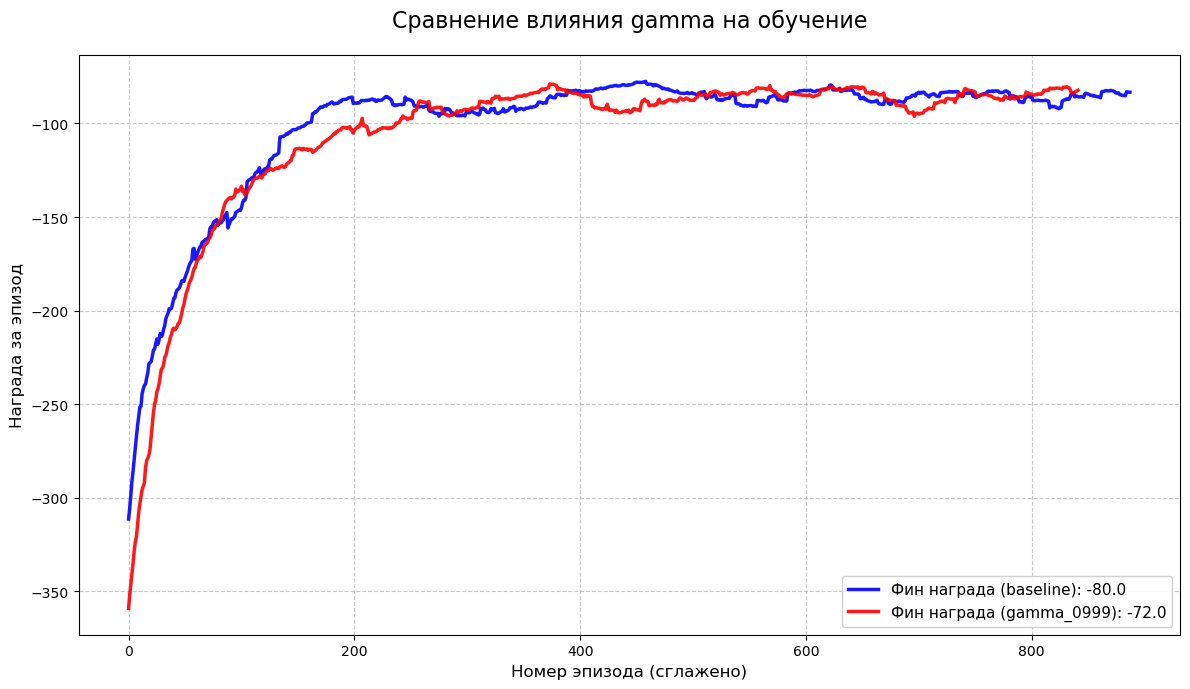

In [ ]:
plt.figure(figsize=(12, 7))

# Построение кривых
plt.plot(range(len(smooth_baseline)), smooth_baseline,
         linewidth=2.5, alpha=0.9, color='blue',
         label=f'Фин награда (baseline): {baseline_rewards[-1]:.1f}')

plt.plot(range(len(smooth_gamma)), smooth_gamma,
         linewidth=2.5, alpha=0.9, color='red',
         label=f'Фин награда (gamma_0999): {gamma_0999_rewards[-1]:.1f}')

# Настройка графика
plt.title('Сравнение влияния gamma на обучение', fontsize=16, pad=20)
plt.xlabel('Номер эпизода (сглажено)', fontsize=12)
plt.ylabel('Награда за эпизод', fontsize=12)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

Результаты эксперимента показывают незначительные различия в производительности: с одной стороны, у модели с gamma=0.999 финальный эпизод показал значительно лучший результат (-73 против -82), но при этом он прошел меньшее число эпизодов (885 против 933, т.е. в среднем ~113 шагов за эпизод против ~107 e baseline), а также имеет более низкую среднюю награду за последние 10 эпизодов (-89.1 против -84.2). Т.о. baseline стабильнее и решает задачу быстрее (overall), в то время как модель с увеличенным gamma имеет более высокие результаты в отдельных эпизодах

Увеличение gamma до 0.999 не привело к значительному улучшению результатов в среде Acrobot-v1, гипотеза не подтвердилась


### Эксперимент 2: Влияние архитектуры сети

In [20]:
# Обучение модели с маленькой архитектурой сети [32, 32]
net_small_model_path, net_small_rewards = train_ppo_model(
    experiment_name="net_small",
    gamma=0.99,
    net_arch=[32, 32],    # Маленькая сеть: 32 нейрона в каждом скрытом слое
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS
)

Эксперимент: net_small
   gamma = 0.99, net_arch = [32, 32]
Среда для 'net_small' создана. Логи: ./logs\net_small/net_small.monitor.csv
Используется кастомная архитектура сети: [32, 32]
Using cpu device
Обучение net_small на 100,000 шагов
Logging to ./logs\net_small\tensorboard\net_small_1


Output()

Модель сохранена в: ./models\ppo_acrobot_net_small.zip
Загружено 890 эпизодов из net_small.monitor.csv


In [21]:
# Запись видео для net_small
net_small_video_path = record_agent_video(
    model_path=net_small_model_path,
    video_name="net_small",
    max_steps=500,
    seed=SEED
)

Запись видео для ppo_acrobot_net_small.zip
    Видео сохранено в: ./videos\net_small.mp4
    Длина эпизода: 84 шагов, суммарная награда: -83.0


In [22]:
# Обучение модели с большой архитектурой сети [256, 256]
net_large_model_path, net_large_rewards = train_ppo_model(
    experiment_name="net_large",
    gamma=0.99,
    net_arch=[256, 256],  # Большая сеть: 256 нейронов в каждом скрытом слое
    seed=SEED,
    total_timesteps=TOTAL_TIMESTEPS
)

Эксперимент: net_large
   gamma = 0.99, net_arch = [256, 256]
Среда для 'net_large' создана. Логи: ./logs\net_large/net_large.monitor.csv
Используется кастомная архитектура сети: [256, 256]
Using cpu device
Обучение net_large на 100,000 шагов
Logging to ./logs\net_large\tensorboard\net_large_1


Output()

Модель сохранена в: ./models\ppo_acrobot_net_large.zip
Загружено 960 эпизодов из net_large.monitor.csv


In [23]:
# Запись видео для net_large
net_large_video_path = record_agent_video(
    model_path=net_large_model_path,
    video_name="net_large",
    max_steps=500,
    seed=SEED
)

Запись видео для ppo_acrobot_net_large.zip
    Видео сохранено в: ./videos\net_large.mp4
    Длина эпизода: 97 шагов, суммарная награда: -96.0


In [25]:
last_10_small = np.mean(net_small_rewards[-10:]) if len(net_small_rewards) >= 10 else np.mean(net_small_rewards)
last_10_large = np.mean(net_large_rewards[-10:]) if len(net_large_rewards) >= 10 else np.mean(net_large_rewards)

print("Средняя награда за последние 10 эпизодов:")
print(f"baseline: {last_10_baseline:.1f}")
print(f"net_small: {last_10_small:.1f}")
print(f"net_large: {last_10_large:.1f}")

Средняя награда за последние 10 эпизодов:
baseline: -84.2
net_small: -81.4
net_large: -75.7


In [ ]:
smooth_small = smooth_rewards(net_small_rewards)
smooth_large = smooth_rewards(net_large_rewards)

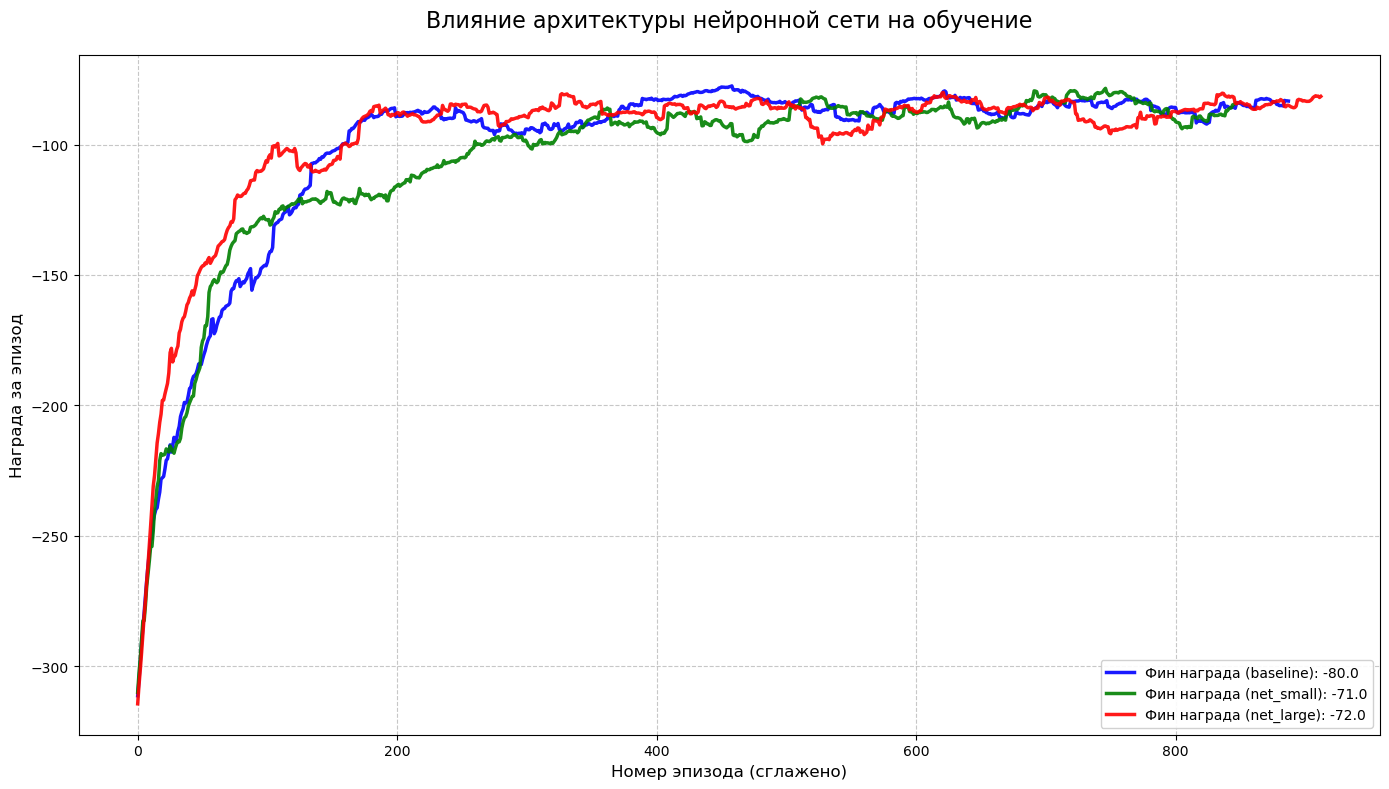

In [ ]:
# Создание графика
plt.figure(figsize=(14, 8))

# Построение кривых
plt.plot(range(len(smooth_baseline)), smooth_baseline,
         linewidth=2.5, alpha=0.9, color='blue',
         label=f'Фин награда (baseline): {baseline_rewards[-1]:.1f}')

plt.plot(range(len(smooth_small)), smooth_small,
         linewidth=2.5, alpha=0.9, color='green',
         label=f'Фин награда (net_small): {net_small_rewards[-1]:.1f}')

plt.plot(range(len(smooth_large)), smooth_large,
         linewidth=2.5, alpha=0.9, color='red',
         label=f'Фин награда (net_large): {net_large_rewards[-1]:.1f}')

plt.title('Влияние архитектуры нейронной сети на обучение', fontsize=16, pad=20)
plt.xlabel('Номер эпизода (сглажено)', fontsize=12)
plt.ylabel('Награда за эпизод', fontsize=12)
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Большая сеть ([256, 256]) научилась решать задачу быстрее в среднем, что подтверждает её преимущество в усвоении сложных паттернов (960 эпизодов против 933 у baseline и 890 у маленькой сети)

Также большая сеть имеет более высокую среднюю награду за последние 10 эпизодов (-75.7 против -81.4 у маленькой сети и -84.2 у baseline)

При этом, если сравнивать финальные результаты, то тут большая сеть окалась на втором месте (-72), уступив маленькой (-71, лучший результат). Baseline показала себя хуже всех: -80

Результаты в финальном видео противоречат вышеперчисленным тенденциям:
- baseline: 83 шага, награда -82.0
- net_small: 84 шага, награда -83.0
- net_large: 97 шагов, награда -96.0

Данная разнонаправленность характерна для RL: результаты в отдельных эпизодах могут сильно отличаться от средних показателей из-за случайной вариативности начального состояния и/или разницы между обучением и оценкой

В среде Acrobot-v1 архитектура нейронной сети оказывает существенное влияние на качество обучения. Увеличение capacity сети (с [64,64] до [256,256]) повышает среднюю производительность на 10%, но может снижать стабильность в отдельных эпизодах. Архитектура по умолчанию ([64,64]) обеспечивает оптимальный баланс между производительностью и стабильностью

Возможные варианты для дальнейших исследований:
- Добавить регуляризацию (dropout) для больших сетей для повышения стабильности
- Провести multiple runs с разными seed для оценки дисперсии результатов
- Увеличить количество шагов обучения до 200-500К для проверки долгосрочной сходимости